In [55]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

In [56]:
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'STIXGeneral'

In [57]:
def calcCoords(n, b, phi, alpha, R, p):
    coords = np.zeros((p, 3))
    index = 0

    for i in range(p):
        if (i != 0) and (i % n) == 0:
            index += 1

        coords[i] = np.array([round(R * math.cos(i * phi + index * alpha), 5), round(R * math.sin(i * phi + index * alpha), 5), index * b])

    return coords

In [58]:
def obtainLocVars(n, a, p, E_2s, E_2p, m, l, k, coords):
    E_2s_loc, E_2p_loc, r, calc_exp, coords = 0, 0, 1, 0, coords.copy()

    if l - m == 0:
        E_2s_loc = E_2s
        E_2p_loc = E_2p

    if (abs(l - m) == p - n) or (abs(l - m) == n) or (((abs(l - m) == 1) or (abs(l - m) == n - 1)) and (coords[l][2] - coords[m][2] == 0)):
        if abs(l - m) == p - n:
            coords[l][2] = coords[l][2] + np.sign(m - l) * a
            
        calc_exp = np.exp(-1j * k * (coords[l][2] - coords[m][2]))
        r = math.sqrt((coords[l][0] - coords[m][0]) ** 2 + (coords[l][1] - coords[m][1]) ** 2 + (coords[l][2] - coords[m][2]) ** 2)

    return E_2s_loc, E_2p_loc, r, calc_exp, coords

In [59]:
def createHamiltBlock(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, m, l, k, coords):
    E_2s_loc, E_2p_loc, r, calc_exp, coords = obtainLocVars(n, a, p, E_2s, E_2p, m, l, k, coords)
    hamilt_block = np.zeros([4, 4], dtype = complex)

    for i in range(1, 5):
        for j in range(1, 5):
            if i == j:
                if i == 1:
                    hamilt_block[i - 1][j - 1] = E_2s_loc - t_ss_sgm * calc_exp
                else:
                    hamilt_block[i - 1][j - 1] = E_2p_loc - ((((coords[l][i - 2] - coords[m][i - 2]) / r) ** 2) * t_pp_sgm + (1 - ((coords[l][i - 2] - coords[m][i - 2]) / r) ** 2) * t_pp_p) * calc_exp
            else:
                if i == 1:
                    hamilt_block[i - 1][j - 1] = (coords[l][j - 2] - coords[m][j - 2]) * t_sp_sgm * calc_exp / r
                elif j == 1:
                    hamilt_block[i - 1][j - 1] = -(coords[l][i - 2] - coords[m][i - 2]) * t_sp_sgm * calc_exp / r
                else:
                    hamilt_block[i - 1][j - 1] = -(coords[l][i - 2] - coords[m][i - 2]) * (coords[l][j - 2] - coords[m][j - 2]) * (t_pp_sgm - t_pp_p) * calc_exp / (r ** 2)

    return hamilt_block

In [60]:
def createHamilt(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, k, coords):
    hamilt = np.zeros([4 * p, 4 * p], dtype = complex)

    for i in range(0, 4 * p, 4):
        for j in range(0, 4 * p, 4):
            hamilt[i: i + 4, j: j + 4] = createHamiltBlock(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, i // 4, j // 4, k, coords)

    return hamilt

In [61]:
def calcEigVals(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, k, coords):
    hamilt = createHamilt(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, k, coords)
    eig_vals_res = np.linalg.eigvals(hamilt).real
    eig_vals_res.sort()

    return eig_vals_res

In [62]:
def calcBandGap(eig_vals_res):
    max_val = (np.max(eig_vals_res[:, 0]))
    min_cond = (np.min(eig_vals_res[:, 1]))
    band_gap = round(max((min_cond.real - max_val.real), 0.00), 2)

    return band_gap

In [63]:
def plotBandStr(n, a, k, eig_vals_res):
    x_lim = math.pi / a
    x_tick = np.array([-x_lim, 0, x_lim])
    x_label = [r"- $\frac{\pi}{a}$", r"$0$", r"$\frac{\pi}{a}$"]

    fig = plt.figure(figsize = (5, 4))

    ax = fig.add_subplot(111)
    ax.plot(k, eig_vals_res, color = 'black', linewidth = 0.5)
    ax.set_xticks(x_tick)
    ax.set_xticklabels(x_label, fontsize = 12)
    ax.set_xlabel(r"$k$", fontsize = 12)
    ax.set_ylabel(r"$E,\ \mathrm{eV}$", fontsize = 12)
    ax.set_xlim([-x_lim, x_lim])

    plt.savefig(f"[{n}; inf]CPP_band_str.eps")
    plt.show()

In [64]:
n = 5
alpha = 10
a = 1.55
b = 1.55

In [65]:
t_ss_sgm = -4.30
t_sp_sgm = 4.98
t_pp_sgm = 6.38
t_pp_p = -2.66
E_2s = -7.30
E_2p = 0.00

In [66]:
phi = 360 / n
alpha = alpha - round(alpha / phi) * phi
phi = phi * math.pi / 180
alpha = alpha * math.pi / 180
R = a / (2 * math.sin(phi / 2))
p = int(2 * math.pi * n / abs(alpha))
a = p * b / n

In [67]:
k = np.linspace(-math.pi / a, math.pi / a, 300)

Band Gap = 2.01 eV


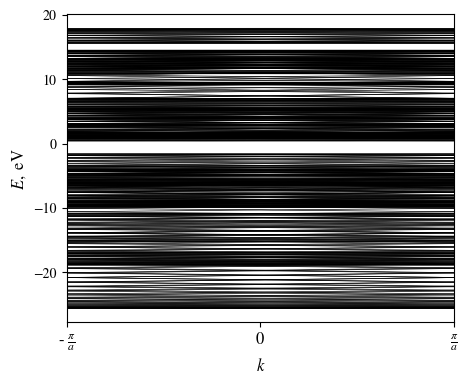

In [68]:
coords = calcCoords(n, b, phi, alpha, R, p)
eig_vals_res = np.array([calcEigVals(n, a, p, E_2s, E_2p, t_ss_sgm, t_sp_sgm, t_pp_sgm, t_pp_p, i, coords) for i in k])
print(f"Band Gap = {calcBandGap(eig_vals_res[:, 2 * p - 1: 2 * p + 1])} eV")
plotBandStr(n, a, k, eig_vals_res)